In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import morton
import numpy as np
import os

### Constants and functions

In [3]:
OFFSET = 10
FACTOR_MULTIPLY = 10000

m = morton.Morton(dimensions=2, bits=18)

def set_value(row):
    return m.pack(int(row['IMULatAcceleration']), int(row['SteeringWhlAngle']))

In [4]:
All_LCs_dir = "./data/2022-09-21_LaneChanges/Extracted_CleanLaneChanges/All_LCs/"
Left_LCs_dir = "./data/2022-09-21_LaneChanges/Extracted_CleanLaneChanges/Left_LCs/"
Right_LCs_dir = "./data/2022-09-21_LaneChanges/Extracted_CleanLaneChanges/Right_LCs/"

### Find lane changes to manipulate based on amplitude

In [5]:
chosen_directory = Right_LCs_dir

LCs_SteeringWhAngle_amplitudes = {}

# iterate through LCs individually
for file in os.listdir(chosen_directory):
    df = pd.read_csv(chosen_directory + file, sep=';')
    # for each extract:
    min_steering = df['SteeringWhlAngle'].min()
    max_steering = df['SteeringWhlAngle'].max()
    # measure amplitude between min and max of LC
    steering_amplitude = max_steering + abs(min_steering) # use abs() to get positive out of the negative value
    # store amplitudes in dictionary (key-value pair)
    LCs_SteeringWhAngle_amplitudes[file] = steering_amplitude

sorted_amplitudes = sorted(LCs_SteeringWhAngle_amplitudes.values())
# take lowest, mid, and highest amplitude
min_amp = sorted_amplitudes[0]
mid_amp = sorted_amplitudes[int(len(sorted_amplitudes)/2)]
max_amp = sorted_amplitudes[len(sorted_amplitudes)-1]
# find LCs to manipulate
for file, amp in LCs_SteeringWhAngle_amplitudes.items():
    if(amp == min_amp):
        LC_min_amp = file
    elif(amp == mid_amp):
        LC_mid_amp = file
    elif(amp == max_amp):
        LC_max_amp = file

### Coefficients for amplitude manipulation

In [6]:
# Starting from mid, we calculate coefficient for amplitude manipulation
# increase amplitude coefficient:
# take amplitude from the mid and max LCs
average_amp = (mid_amp + max_amp) / 2
increase_amp_coefficient = average_amp / mid_amp

# decrease amplitude coefficient:
# take amplitude from the mid and min LCs
average_amp = (mid_amp + min_amp) / 2
decrease_amp_coefficient = average_amp / mid_amp

### Manipulating the LC, and Morton encoding

In [7]:
# create df for mid amplitude LC
df_LC_mid_amp = pd.read_csv(chosen_directory + LC_mid_amp, sep=';')
# make a copy for the manipulated versions
df_amp_increased = df_LC_mid_amp.copy()
df_amp_decreased = df_LC_mid_amp.copy()

In [8]:
# manipulate the LC by multiplying each data point by coefficient
df_amp_increased['SteeringWhlAngle'] = df_amp_increased['SteeringWhlAngle'].apply(lambda x: x*increase_amp_coefficient)
df_amp_increased_no_constants = df_amp_increased.copy()

# Apply constants for Morton encoding
df_amp_increased['IMULatAcceleration']=df_amp_increased['IMULatAcceleration'].add(OFFSET)
df_amp_increased['SteeringWhlAngle']=df_amp_increased['SteeringWhlAngle'].add(OFFSET)
df_amp_increased['IMULatAcceleration'] = df_amp_increased.apply(lambda x: int(x['IMULatAcceleration']*FACTOR_MULTIPLY) , axis=1)
df_amp_increased['SteeringWhlAngle'] = df_amp_increased.apply(lambda x: int(x['SteeringWhlAngle']*FACTOR_MULTIPLY) , axis=1)

# Morton encoding
df_amp_increased['morton'] = df_amp_increased.apply(set_value, axis=1)

In [9]:
# manipulate the LC by multiplying each data point by coefficient
df_amp_decreased['SteeringWhlAngle'] = df_amp_decreased['SteeringWhlAngle'].apply(lambda x: x*decrease_amp_coefficient)
df_amp_decreased_no_constants = df_amp_decreased.copy()

# Apply constants for Morton encoding
df_amp_decreased['IMULatAcceleration']=df_amp_decreased['IMULatAcceleration'].add(OFFSET)
df_amp_decreased['SteeringWhlAngle']=df_amp_decreased['SteeringWhlAngle'].add(OFFSET)
df_amp_decreased['IMULatAcceleration'] = df_amp_decreased.apply(lambda x: int(x['IMULatAcceleration']*FACTOR_MULTIPLY) , axis=1)
df_amp_decreased['SteeringWhlAngle'] = df_amp_decreased.apply(lambda x: int(x['SteeringWhlAngle']*FACTOR_MULTIPLY) , axis=1)

# Morton encoding
df_amp_decreased['morton'] = df_amp_decreased.apply(set_value, axis=1)

### Plots

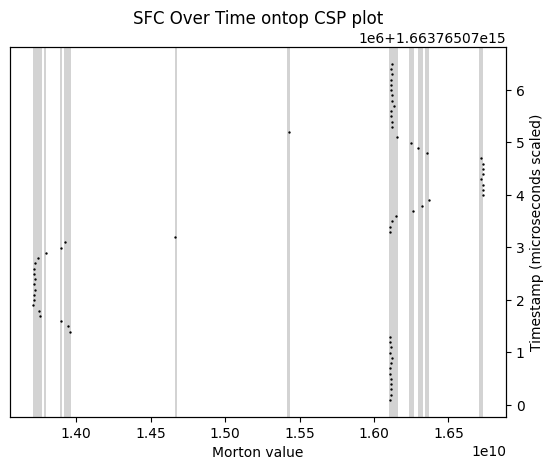

In [10]:
# SFC over time plots

fig, ax = plt.subplots()
ax.hist(df_amp_increased['morton'], bins=200, color='lightgray')
ax.set_ylim([0,1])
plt.gca().set_yticks([]) 
ax2 = ax.twinx()
ax2.scatter(x=df_amp_increased['morton'],y=df_amp_increased['ts'], c='black', s=0.5)
ax.set_xlabel('Morton value')
ax2.set_title("SFC Over Time ontop CSP plot")
ax2.set_ylabel('Timestamp (microseconds scaled)')
plt.show()


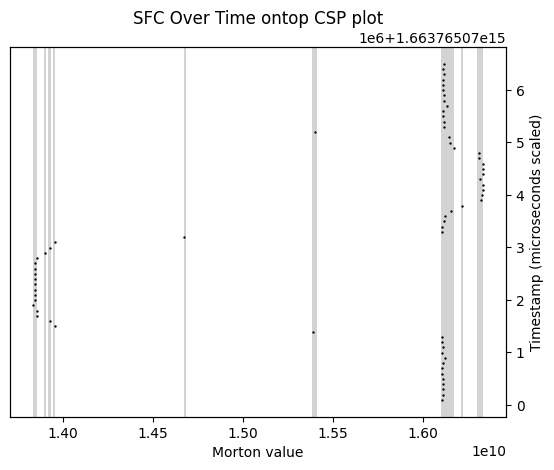

In [11]:
# Plot results

fig, ax = plt.subplots()
ax.hist(df_amp_decreased['morton'], bins=200, color='lightgray')
ax.set_ylim([0,1])
plt.gca().set_yticks([]) 
ax2 = ax.twinx()
ax2.scatter(x=df_amp_decreased['morton'],y=df_amp_decreased['ts'], c='black', s=0.5)
ax.set_xlabel('Morton value')
ax2.set_title("SFC Over Time ontop CSP plot")
ax2.set_ylabel('Timestamp (microseconds scaled)')
plt.show()

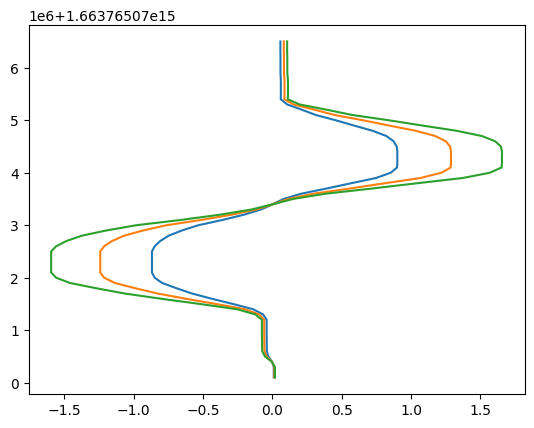

In [12]:
plt.plot(df_amp_decreased_no_constants['SteeringWhlAngle'], df_amp_decreased_no_constants['ts'], label = "LC_amp_decreased")
plt.plot(df_LC_mid_amp['SteeringWhlAngle'], df_LC_mid_amp['ts'], label = "LC_mid_amp")
plt.plot(df_amp_increased_no_constants['SteeringWhlAngle'],df_amp_increased_no_constants['ts'], label = "LC_amp_increased")

### Manipulating LC 27 (for simulator generation)

In [14]:
# Creating the coefficients

# LC 27 is the reference lane change
LC27 = "./data/2022-09-21_LaneChanges/SteeringWheelAngle_Separated/50Hz/SteeringWheelAngle-50Hz-27.csv"
df_LC27 = pd.read_csv(LC27, sep=';')

extra_amp = 0.5
step = 0.35

# Make 5 LCs with harsher steering (can go harsher than harshest)
# List of desired increase amplitudes
desired_increase_amplitudes = np.arange(mid_amp, max_amp +extra_amp, step).tolist()
# List of coefficients to achieve those amplitudes
increase_amp_coefficients = []

for i in range(1, len(desired_increase_amplitudes)):
    # Populate the list by dividing the current desired amplitude by the original one (index 0)
    increase_amp_coefficients.append(desired_increase_amplitudes[i] / desired_increase_amplitudes[0])
    
# Make 5 LCs with less harsh steering
# List of desired decrease amplitudes
desired_decrease_amplitudes = np.arange(min_amp-extra_amp, mid_amp, step).tolist()
# List of coefficients to achieve those amplitudes
decrease_amp_coefficients = []

for i in range(1, len(desired_decrease_amplitudes)):
    # Populate the list by dividing the original amplitude by the current desired one
    decrease_amp_coefficients.append(desired_decrease_amplitudes[0] / desired_decrease_amplitudes[i])
decrease_amp_coefficients

[0.5929123125851886,
 0.4213755247013239,
 0.3268219383921864,
 0.2669257516874617,
 0.22558340535868626]

In [159]:
# Lists that will contain manipulated dfs
df_LC27_increased_arr = []
df_LC27_decreased_arr = []

In [160]:
# Manipulating steering by increase
for i in range(0, len(increase_amp_coefficients)):
    curr_df = df_LC27.copy()
    # manipulate the LC by multiplying each data point by coefficient
    curr_df['SteeringWhlAngle'] = curr_df['SteeringWhlAngle'].apply(lambda x: x*increase_amp_coefficients[i])

    # Save in list of all increased versions
    df_LC27_increased_arr.append(curr_df)

In [161]:
# Manipulating steering by decrease
for i in range(0, len(decrease_amp_coefficients)):
    curr_df = df_LC27.copy()
    # manipulate the LC by multiplying each data point by coefficient
    curr_df['SteeringWhlAngle'] = curr_df['SteeringWhlAngle'].apply(lambda x: x*decrease_amp_coefficients[i])

    # Save in list of all decreased versions
    df_LC27_decreased_arr.append(curr_df)

In [166]:
# Output to csv
# LCs with increased steering
for i in range(0, len(df_LC27_increased_arr)):
    df_LC27_increased_arr[i].to_csv('./data/lane_changes_manipulated/LC27_50Hz_steering_increased_' + str(i), sep=';', index=False)

# LCs with decreased steering
for i in range(0, len(df_LC27_decreased_arr)):
    df_LC27_decreased_arr[i].to_csv("./data/lane_changes_manipulated/LC27_50Hz_steering_decreased_" + str(i), sep=';', index=False)
